# Data Import

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src

sys.path.append('../../kungfu/')
import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

In [6]:
#sample_start = dt.datetime(1962,1,1)
#sample_start = dt.datetime(1945,1,1)
sample_start = dt.datetime(1900,1,1)

#sample_end = dt.datetime(2019,12,31)
sample_end = dt.datetime.today()

### Predictor data

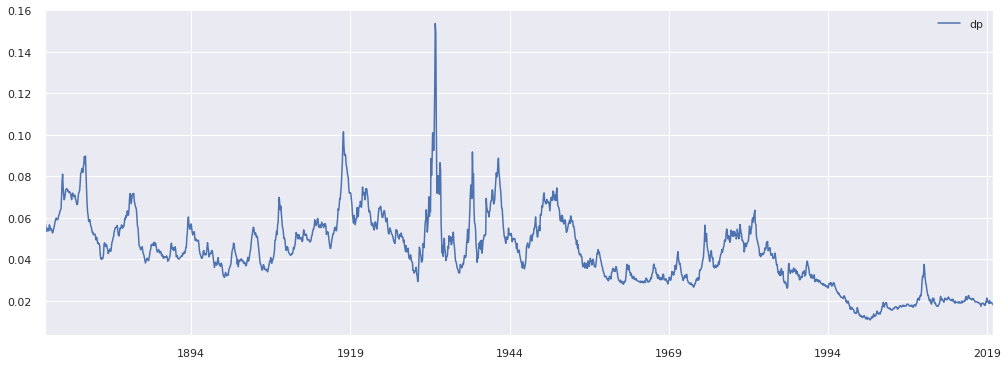

In [7]:
from src.data import download_goyal_welch

df_predictors = download_goyal_welch()
df_predictors['dp'] = df_predictors.D12/df_predictors.Index

df_predictors[['dp']].plot(figsize=[17,6])
plt.show()

In [20]:
df_predictors.to_pickle(path='../data/external/df_predictors.pkl')

### Market Index

In [7]:
factors_daily = kf.dataloader.download_factor_data('D')/100
factors_monthly = kf.dataloader.download_factor_data('M')/100

factors_daily = factors_daily.loc[(factors_daily.index >= sample_start) & (factors_daily.index <= sample_end)]
factors_monthly = factors_monthly.loc[(factors_monthly.index >= sample_start) & (factors_monthly.index <= sample_end)]

market_daily = factors_daily['Mkt-RF'].set_obstype('return')
market_monthly = factors_monthly['Mkt-RF'].set_obstype('return')

market_daily.to_pickle(path='../data/external/market_daily.pkl')
market_monthly.to_pickle(path='../data/external/market_monthly.pkl')

print('downloaded FF Market data: ' + str(dt.datetime.now()))

downloaded FF Market data: 2020-07-26 17:58:29.647411


### Aggregation

In [8]:
fdf_market = kf.FinancialDataFrame([])
month_groups = market_daily.groupby([(market_daily.index.year),(market_daily.index.month)])
fdf_market['obs_count'] = month_groups.count()

for group in month_groups:
    fdf_market.at[group[0],'real_volatility'] = group[1].calculate_realised_volatility(252)
    fdf_market.at[group[0],'tot_return'] = group[1].calculate_total_return()

In [19]:
market_returns = market_monthly.copy()
market_returns.name = 'monthly_return'
market_returns.index = pd.MultiIndex.from_arrays([market_returns.index.year, market_returns.index.month])
fdf_market = fdf_market.join(market_returns, how='left')

In [20]:
fdf_market

obs_count  real_volatility  tot_return  monthly_return
Date Date                                                        
1926 7            25           0.0727      0.0288          0.0296
     8            26           0.0937      0.0267          0.0264
     9            24           0.0771      0.0037          0.0036
     10           25           0.1321     -0.0330         -0.0324
     11           24           0.0617      0.0258          0.0253
...              ...              ...         ...             ...
2019 10           23           0.1320      0.0206          0.0206
     11           20           0.0676      0.0388          0.0387
     12           21           0.0778      0.0278          0.0277
2020 1            21           0.1160     -0.0010         -0.0011
     2            19           0.2497     -0.0811         -0.0813

[1124 rows x 4 columns]

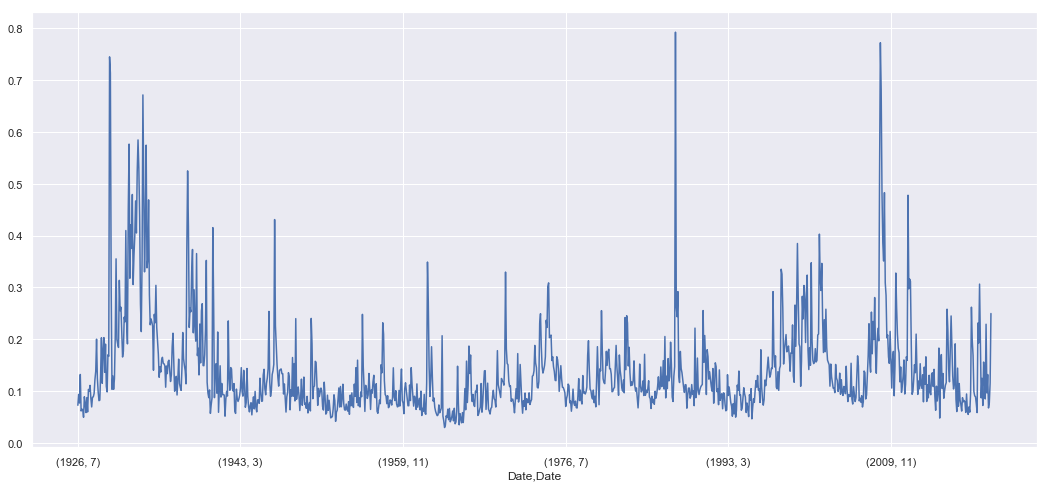

In [21]:
fdf_market.real_volatility.plot(figsize=[18,8])